In [1]:
%pylab inline --no-import-all
import cv2
import keras
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential, Model
import keras.backend as K
import sys
import os
import skimage
import skimage.transform
import skimage.exposure

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


(25, 100)


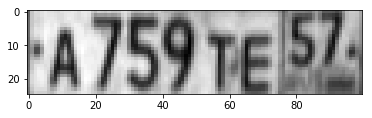

In [22]:
sample_img = cv2.cvtColor(plt.imread(os.path.join("data/rus/segmentation/src/", os.listdir("data/rus/segmentation/src")[0])),
                          cv2.COLOR_RGBA2GRAY)
plt.imshow(sample_img, cmap='gray')
print(sample_img.shape)

In [21]:
input_dim = (100, 25, 1)
output_dim = (100, 1)
image_area = input_dim[0] * input_dim[1]

In [142]:
def train_data_gen(srcPath, dstPath, inputDim, outputDim, batchSize=100):
    srcs = np.zeros((batchSize, *inputDim))
    dsts = np.zeros((batchSize, *outputDim))
    
    for idx, src_node in enumerate(os.scandir(srcPath)):
        i = idx % batchSize
        src = cv2.cvtColor(plt.imread(src_node.path), cv2.COLOR_RGBA2GRAY)
        dst = cv2.cvtColor(plt.imread(os.path.join(dstPath, src_node.name)), cv2.COLOR_RGBA2GRAY)
        srcs[i, :] = src.reshape(inputDim)
        dsts[i, :] = dst.reshape(outputDim)
        if len(srcs) == batchSize:
            yield srcs, dsts
    yield srcs, dsts

(1, 100, 25, 1) (1, 100, 1)


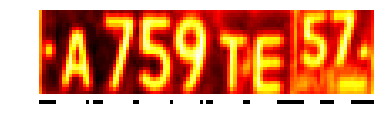

In [148]:
src_path = "data/rus/segmentation/src/"
dst_path = "data/rus/segmentation/dst/"

for X, Y in train_data_gen(src_path, dst_path, input_dim, output_dim, batchSize=1):
    src = X
    dst = Y
    print(src.shape, dst.shape)
    plt.subplot(211)
    plt.imshow(src.reshape(input_dim[0:2][::-1]), cmap='hot_r')
    plt.axis("off")
    plt.subplot(212)
    plt.imshow(dst.reshape(output_dim[:2][::-1]), cmap='gray')
    plt.axis("off")
    plt.subplots_adjust(hspace=-0.7)
    break

In [172]:
from keras.objectives import binary_crossentropy

first_layer_filters = 32
second_layer_filters = 16
rnn_height = 16
rnn_units = 32
pre_rnn_shape = (input_dim[0], input_dim[1] * second_layer_filters)

inp = Input(shape=input_dim, name='input')
conv = Conv2D(first_layer_filters, (3, 3), input_shape=input_dim, activation='relu',
              name='conv1', padding='same', kernel_initializer='he_normal')(inp)
conv = Conv2D(second_layer_filters, (3, 3), activation='relu',
              name='conv2', padding='same', kernel_initializer='he_normal')(conv)
rnn = Reshape(pre_rnn_shape)(conv)
rnn = Dense(rnn_height, activation='relu')(rnn)
gru1 = GRU(rnn_units, return_sequences=True)(rnn)
gru2 = GRU(rnn_units, return_sequences=True, go_backwards=True)(rnn)
rnn = Add()([gru1, gru2])
out = Dense(1, activation='sigmoid', kernel_initializer='he_normal', name='output')(rnn)
print(out)

model = Model(inp, out)

model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])

Tensor("output_10/Sigmoid:0", shape=(?, 100, 1), dtype=float32)


In [175]:
from progressbar import FormatCustomText, ProgressBar, Counter, Bar

def train(model, dataset, batch_size=10, epochs=1):
    src_path = f"data/{dataset}/segmentation/src/"
    dst_path = f"data/{dataset}/segmentation/dst/"

    train_count = len(os.listdir(dst_path))
    train_batches = train_count // batch_size

    model.fit_generator(train_data_gen(src_path, dst_path, input_dim, output_dim, batch_size),
                        epochs=epochs, steps_per_epoch=train_batches)
    return
    for epoch in range(epochs):
        counter = Counter()
        text = FormatCustomText('loss: %(loss).6f, acc: %(acc).6f', mapping={"loss": 1, "acc": 0})
        progress = ProgressBar(widgets=['[' , counter, '/' , str(train_batches), '] ', Bar(), text], 
                               min_value = 1,
                               max_value=train_batches,
                               marker='-')

        with sess.as_default():
            for x, y in progress(train_data_gen(src_path, dst_path, input_dim, output_dim, batch_size)):
                _, loss_value, acc_value = sess.run([train_step, loss, accuracy], feed_dict={inp: X, out: Y})
                text.update_mapping(loss=loss_value, acc=acc_value)

    
train(model, "rus", 4, 3)
#train("bel", 10, 1)

Epoch 1/3
303/303 [==============================] - 29s - loss: 0.3582 - binary_accuracy: 0.8323    
Epoch 2/3
303/303 [==============================] - 29s - loss: 0.3574 - binary_accuracy: 0.8332    
Epoch 3/3
303/303 [==============================] - 28s - loss: 0.3986 - binary_accuracy: 0.7993    


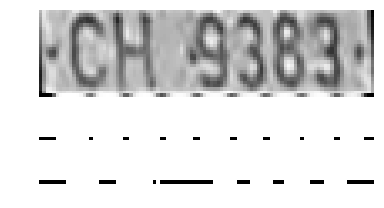

In [176]:
def plot_predictions(dataset, idx=0):
    src_path = f"data/{dataset}/segmentation/src"
    dst_path = f"data/{dataset}/segmentation/dst"
    
    gen = train_data_gen(src_path, dst_path, input_dim, output_dim, batchSize=1)
    for src, dst in gen:
        predicted = model.predict(src)
        plt.subplot(411)
        plt.imshow(src.reshape(input_dim[:2][::-1]), cmap='gray')
        plt.axis("off")
        plt.subplot(412)
        plt.imshow(predicted.reshape(output_dim[:2][::-1]) * 255, cmap='gray')
        plt.axis("off")
        plt.subplot(413)
        plt.axis("off")
        plt.imshow(np.where(predicted > 0.5, 1, 0).reshape(output_dim[:2][::-1]), cmap='gray')
        plt.subplot(414)
        plt.axis("off")
        plt.imshow(dst.reshape(output_dim[:2][::-1]), cmap='gray')
        plt.subplots_adjust(hspace=-0.5)
        break
    

plot_predictions("bel", np.random.randint(100))

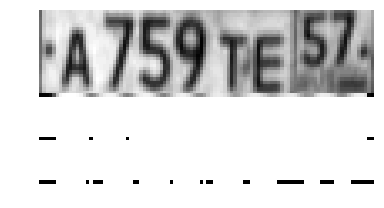

In [177]:
plot_predictions("rus", np.random.randint(100))

In [181]:
src_path = "data/rus/segmentation/src/"
dst_path = "data/rus/segmentation/dst/"

gen = train_data_gen(src_path, dst_path, input_dim, output_dim, batchSize=10)
src, dst = next(gen)

%timeit model.predict(src)

23.8 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
